# Exploratory Analysis


In [1]:
import os

os.chdir("..")
os.getcwd()

'c:\\Users\\Lucius\\Documents\\Insper\\Disciplinas\\ml\\Stock-Price-Prediction-'

In [2]:
from pathlib import Path

import mplfinance as mpf
import pandas as pd
from matplotlib import pyplot as plt

## Fetch datasets

In [ ]:
BASE_URL = "https://data.binance.vision/data/futures/cm/daily/bookTicker/"

datasets= {
    "ADA": [
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}ADAUSD_PERP/ADAUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "AXS": [
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}AXSUSD_PERP/AXSUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "BTC": [
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}BTCUSD_PERP/BTCUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "DOGE": [
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}DOGEUSD_PERP/DOGEUSD_PERP-bookTicker-2024-05-20.zip",
    ],
    "NEAR": [
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-16.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-17.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-18.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-19.zip",
        f"{BASE_URL}NEARUSD_PERP/NEARUSD_PERP-bookTicker-2024-05-20.zip",
    ],
}

In [ ]:
from scripts.pull_datasets import execute as pull_datasets

pull_datasets(datasets)

## Run Preprocessing script

In [ ]:
from scripts.preprocess import execute as preprocess

for ticker in datasets.keys():
    preprocess(ticker)

## Build Open-High-Low-Close charts of `mid_price` for each day

In [91]:
basedir = Path.cwd()
datadir = basedir / "data"
resultsdir = basedir / "assets" / "image"

def to_OHLC(df: pd.DataFrame, pattern: str):
    return df.resample(pattern).agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last"
    })


In [92]:
resultsdir.mkdir(parents=True, exist_ok=True)

for datafile in (datadir / "tickers").glob("**/*-raw.parquet"):
    name = datafile.stem[:-4]
    df = pd.read_parquet(datafile)
    data = to_OHLC(df["mid_price"], "1h")
    data["Volume"] = df["Trades"].resample("1h").agg("sum")
    title = name.replace("_", " ").replace("-", " - ")

    mpf.plot(
        data=data,
        type="candle",
        style="binance",
        volume=True,
        title=title,
        savefig=resultsdir / (name + "-ohlc.svg"),
    )


1

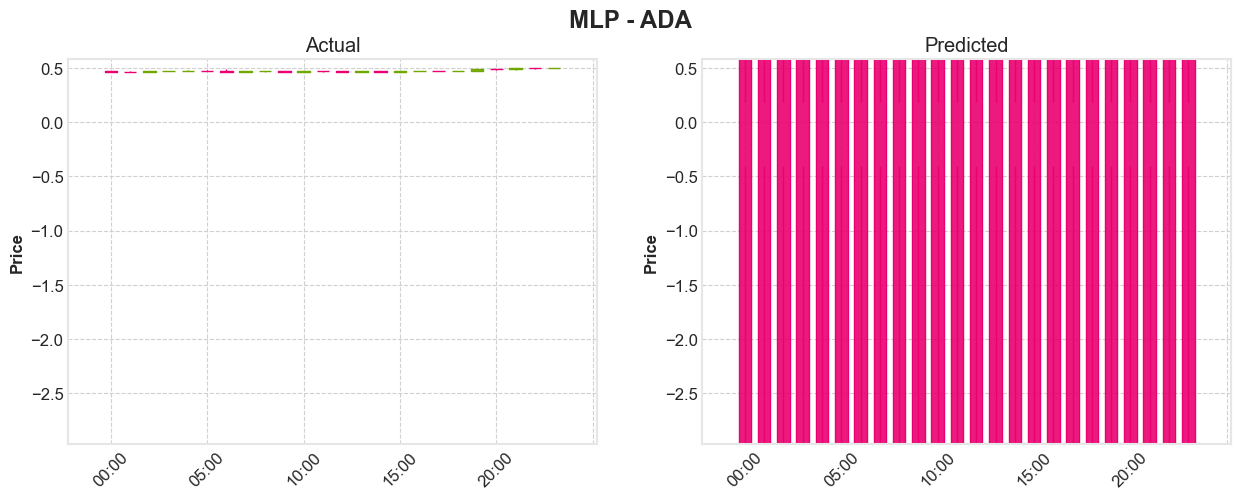

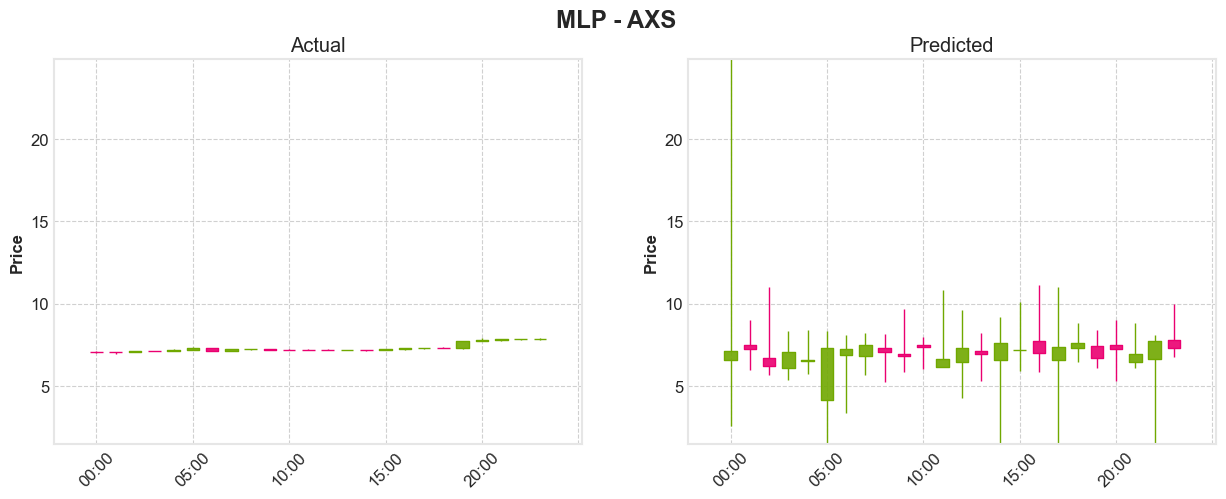

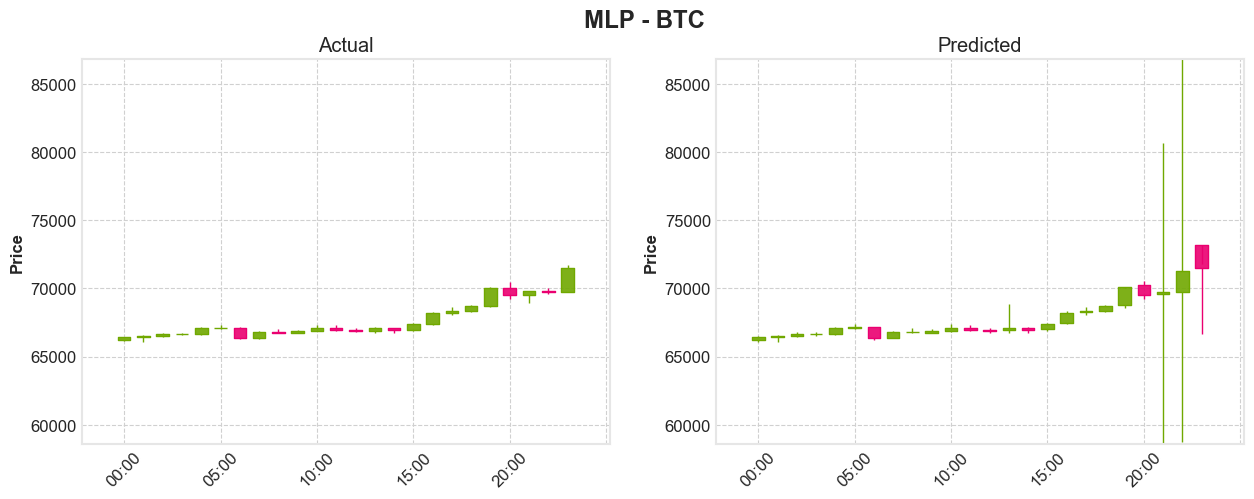

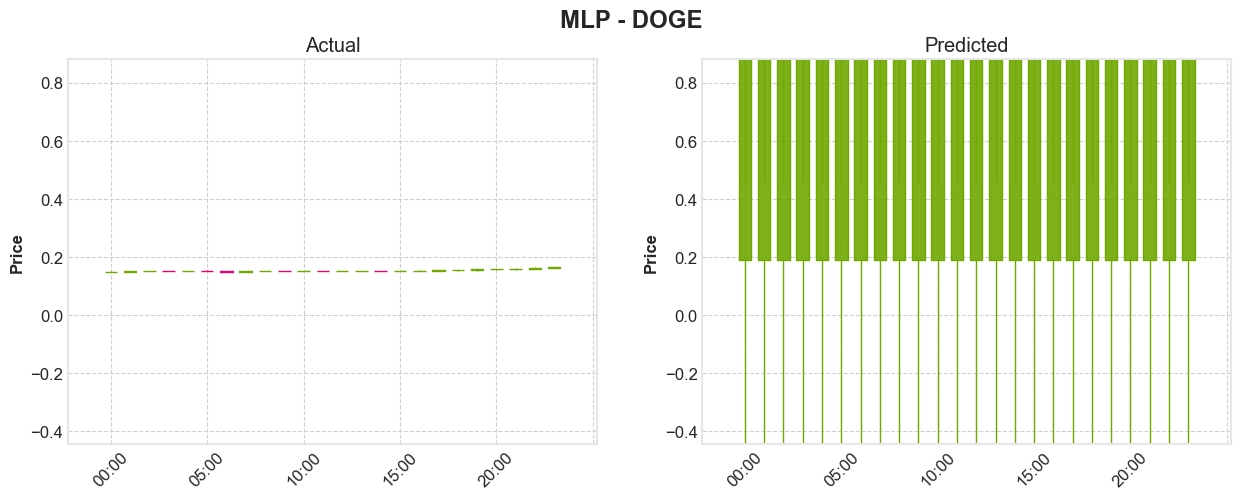

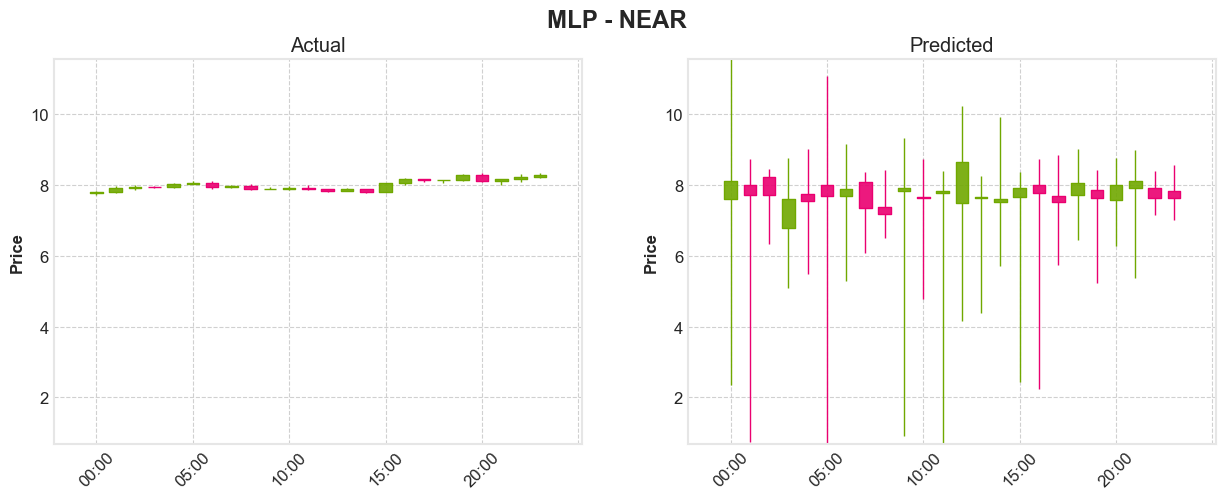

In [106]:
validation_datafiles = (datadir / "tickers").glob("**/*-day_5-raw.parquet")
prediction_datafiles = (datadir / "predictions").glob("MLP-*.parquet")

for y_true, y_hat in zip(validation_datafiles, prediction_datafiles):
    title = y_hat.stem.replace("-", " - ")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    fig.suptitle(title)
    ax1.set_title("Actual")
    ax2.set_title("Predicted")

    data1 = to_OHLC(pd.read_parquet(y_true)["mid_price"], "1h")
    data2 = to_OHLC(pd.read_parquet(y_hat), "1h")
    combined_ymin = min(data1.min().min(), data2.min().min())
    combined_ymax = max(data1.max().max(), data2.max().max())

    ax1.set_ylim(combined_ymin, combined_ymax)
    ax2.set_ylim(combined_ymin, combined_ymax)

    mpf.plot(data1, type="candle", style="binance", ax=ax1)
    mpf.plot(data2, type="candle", style="binance", ax=ax2)
    plt.savefig(resultsdir / y_hat.with_suffix(".svg").name)

1